## Exercise 2

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import null_space

In [ ]:
nodes = ['o', 'a', 'b', 'c', 'd']
node_idx = {n: i for i, n in enumerate(nodes)}
num_nodes = len(nodes)

# Transition matrix Lambda
Lambda = np.zeros((num_nodes, num_nodes))

# o -> a (2/5), o -> b (1/5)
Lambda[node_idx['o'], node_idx['a']] = 0.4
Lambda[node_idx['o'], node_idx['b']] = 0.2

# a -> b (3/4), a -> c (1/4)
Lambda[node_idx['a'], node_idx['b']] = 0.75
Lambda[node_idx['a'], node_idx['c']] = 0.25

# b -> o (1/2), b -> c (1/3)
Lambda[node_idx['b'], node_idx['o']] = 0.5
Lambda[node_idx['b'], node_idx['c']] = 1/3

# c -> b (1/3), c -> d (2/3)
Lambda[node_idx['c'], node_idx['b']] = 1/3
Lambda[node_idx['c'], node_idx['d']] = 2/3

# d -> a (1/3), d -> c (1/3)
Lambda[node_idx['d'], node_idx['a']] = 1/3
Lambda[node_idx['d'], node_idx['c']] = 1/3

# omega contains the rate of total exit for each node
omega = np.sum(Lambda, axis=1)
omega_star = np.max(omega)  # max exit rate for global uniformization

# Local jump probability matrix
P = np.linalg.inv(np.diag(omega)) @ Lambda

# Global jump probability matrix (uniformization)
P_bar = np.zeros_like(Lambda)
P_bar = Lambda / omega_star
for i in range(num_nodes):
    P_bar[i, i] = 1.0 - np.sum(P_bar[i, :])


# Laplacian =  diag(omega) - Lambda
L = np.diag(omega) - Lambda
# L' * pi_bar = 0 
pi_basis = null_space(L.T)
# Stationary Distribution
pi_theoretical = pi_basis[:, 0] / np.sum(pi_basis[:, 0]) # Normalization
# TODO --> è il pi_bar delle slides ?? verificare perché nelle slide dice pi != pi_bar

print("Exit rates (omega):", dict(zip(nodes, np.round(omega, 3))))
print("Stationary distribution (pi):", dict(zip(nodes, np.round(pi_theoretical, 3))))
expected_return_a = 1 / (pi_theoretical[node_idx['a']] * omega[node_idx['a']])
print(f"Theoretical expected return time for 'a': {expected_return_a:.4f}")

Exit rates (omega): {'o': np.float64(0.6), 'a': np.float64(1.0), 'b': np.float64(0.833), 'c': np.float64(1.0), 'd': np.float64(0.667)}
Stationary distribution (pi): {'o': np.float64(0.217), 'a': np.float64(0.149), 'b': np.float64(0.261), 'c': np.float64(0.186), 'd': np.float64(0.186)}
Theoretical expected return time for 'a': 6.7083


In [66]:
# Particle perspective simulation

def simulate_particle_return_time(start_node_idx, n_particles):
    
    # TODO verificare dove viene detto o si deduce che le particelle sono indipendenti

    return_times = []
    
    for _ in range(n_particles):
        current_node = start_node_idx
        time_elapsed = 0.0
        has_left = False
        
        while True:
            # 1. Determina tempo di permanenza (Exp(omega_i)) TODO questo sarebbe il poisson clock per ogni singola particella??
            rate = omega[current_node]
            dt = np.random.exponential(1/rate) # TODO --> verificare formula tra slide e lab
            time_elapsed += dt
            
            # 2. Determina prossimo nodo basandosi su P
            next_node = np.random.choice(num_nodes, p=P[current_node])
            
            # Logica ritorno: deve lasciare il nodo e poi tornare
            if current_node == start_node_idx:
                if has_left: 
                    # È tornato! (Nota: time_elapsed include l'attesa prima di entrare qui? 
                    # No, include l'attesa nel nodo corrente PRIMA di saltare a next_node)
                    # Se next_node è start_node, è un ritorno.
                    pass
            
            prev_node = current_node
            current_node = next_node
            
            if prev_node == start_node_idx:
                has_left = True
            
            # Se siamo nel nodo target ed eravamo già usciti
            if current_node == start_node_idx and has_left:
                return_times.append(time_elapsed)
                break
                
    return np.array(return_times)

N_particles = 100
return_times = simulate_particle_return_time(node_idx['a'], N_particles)
avg_return_time = np.mean(return_times)
print(f"Number of particles: {N_particles}")
print(f"Average return time simulated (start a -> ... -> a): {avg_return_time:.4f}")
print(f"Comparison with theoritcal ({expected_return_a:.4f}): {'Close' if abs(avg_return_time - expected_return_a) < 1.0 else 'Distant'}")


Number of particles: 100
Average return time simulated (start a -> ... -> a): 6.1287
Comparison with theoritcal (6.7083): Close


In [ ]:
# Node perspective simulation
def simulate_node_perspective(start_dist, total_time, n_particles=100):
    """
    Simula il sistema aggregato.
    start_dist: array con conteggi iniziali per nodo [n_o, n_a, ...]
    """
    counts = np.array(start_dist, dtype=int)
    current_time = 0.0
    
    # Per il plotting
    times = [0.0]
    history = [counts.copy()]
    
    while current_time < total_time:
        # global Poisson clock rate 
        total_system_rate = num_nodes * omega_star
        
        if total_system_rate == 0:
            break # no particles moving (impossible with given graph)
            
        # time to next event (global exponential)
        dt = np.random.exponential(1 / total_system_rate)
        current_time += dt
        
        if current_time > total_time:
            break

        # choose which node moves a particle (proportional to particles number)
        source_node = np.random.choice(num_nodes, p=counts/n_particles)
        
        # use P_bar to choose where the particle jumps
        target_node = np.random.choice(num_nodes, p=P_bar[source_node])
        
        # update states
        counts[source_node] -= 1
        counts[target_node] += 1
        
        times.append(current_time)
        history.append(counts.copy())
        
    return np.array(times), np.array(history)

initial_counts = [0, 100, 0, 0, 0] # every particle starts in 'a'
T_max = 60
times, history = simulate_node_perspective(initial_counts, T_max, N_particles)

final_counts = history[-1]
expected_counts = pi_theoretical * 100 # TODO --> verificare slide lab o specifica hw

print(f"Conteggi finali simulati (t={T_max}):")
print(dict(zip(nodes, final_counts)))
print("Conteggi teorici stazionari (N * pi):")
print(dict(zip(nodes, np.round(expected_counts, 1))))

Conteggi finali simulati (t=60):
{'o': np.int64(24), 'a': np.int64(16), 'b': np.int64(27), 'c': np.int64(17), 'd': np.int64(16)}
Conteggi teorici stazionari (N * pi):
{'o': np.float64(21.7), 'a': np.float64(14.9), 'b': np.float64(26.1), 'c': np.float64(18.6), 'd': np.float64(18.6)}



Grafico salvato come 'homework2_simulation.pdf'


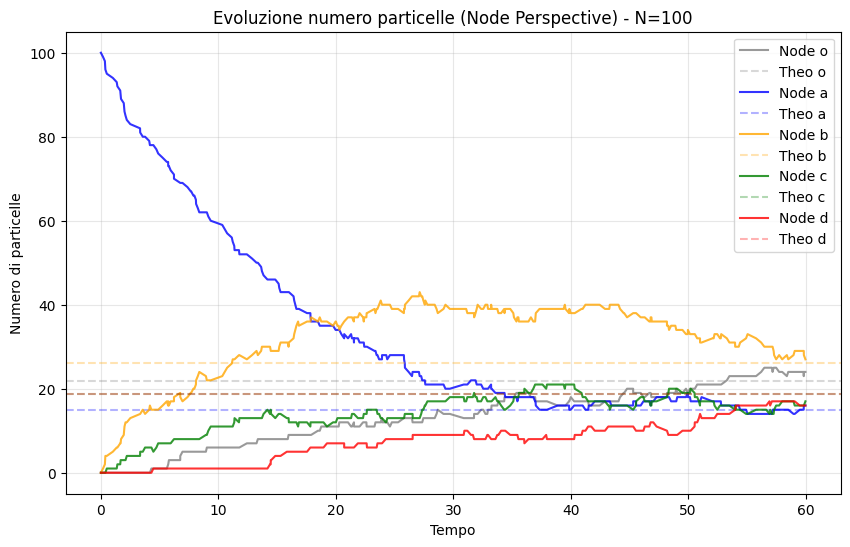

In [ ]:
plt.figure(figsize=(10, 6))
colors = ['gray', 'blue', 'orange', 'green', 'red']
for i in range(num_nodes):
    plt.plot(times, history[:, i], label=f'Node {nodes[i]}', color=colors[i], alpha=0.8)
    plt.axhline(y=expected_counts[i], color=colors[i], linestyle='--', alpha=0.3, label=f'Theo {nodes[i]}')


plt.title(f'Evoluzione numero particelle (Node Perspective) - N={sum(initial_counts)}')
plt.xlabel('Tempo')
plt.ylabel('Numero di particelle')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.savefig('homework2_simulation.pdf')
print("\nGrafico salvato come 'homework2_simulation.pdf'")
plt.show()